In [1]:
import Amoeba
import QuasarModelFunctions as QMF
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from numpy import random
import sys


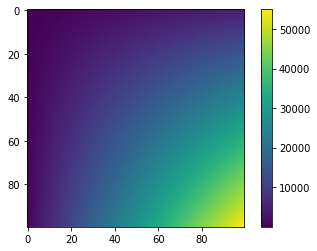

In [2]:
Temp = np.zeros((100,100))
Vmap = np.zeros(np.shape(Temp))
Gmap = np.ones(np.shape(Temp))
for jj in range(np.size(Temp, 0)):
    for kk in range(np.size(Temp, 1)):
        Temp[jj, kk] = jj*10 + kk*50 + jj*kk*5 + 10
image = plt.imshow(Temp)
plt.colorbar(image)

In [3]:
MEXP = 7.0
mass = 10**MEXP * const.M_sun.to(u.kg)

redshift = 2.0
inc_angle = 40
nGRs = 100

In [4]:
DiskModel = Amoeba.ThinDisk(MEXP,redshift,nGRs, inc_angle,Temp,Vmap,Gmap,name='Testing')

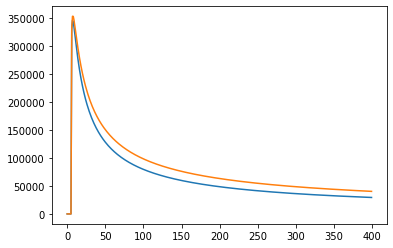

In [5]:
x = np.linspace(1, 400, 400)
temps0 = np.zeros(np.shape(x))
temps1 = np.zeros(np.shape(x))
beta=0.3
M_acc = const.M_sun/u.yr
for jj in x:
    temps0[int(jj-1)] = QMF.AccDiskTemp(jj*QMF.GetGeometricUnit(mass), 6*QMF.GetGeometricUnit(mass), M_acc, mass).value
    temps1[int(jj-1)] = QMF.AccDiskTempBeta(jj*QMF.GetGeometricUnit(mass), 6*QMF.GetGeometricUnit(mass), M_acc, mass, beta)
#fig, ax=plt.subplots(figsize=(12,9))
plt.plot(temps0)
plt.plot(temps1)


In [6]:
BrightnessMap = DiskModel.CreateRestSurfaceIntensityMap(200)

/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:226: RuntimeWarning: overflow encountered in power
  return (2.0 * h.value * c.value**(2.0) * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input


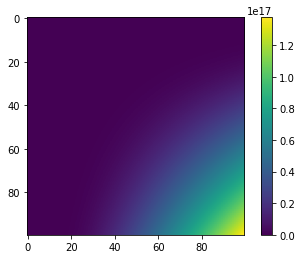

In [7]:
image2 = plt.imshow((BrightnessMap))
plt.colorbar(image2)

In [8]:
DerMap = DiskModel.CreateReprocessedEmissionMap(400)

/usr/local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/henrybest/PythonStuff/Code/Amoeba.py:123: RuntimeWarning: overflow encountered in square
  return a.value * b.value / (b.value - 1)**2
/Users/henrybest/PythonStuff/Code/Amoeba.py:123: RuntimeWarning: invalid value encountered in true_divide
  return a.value * b.value / (b.value - 1)**2


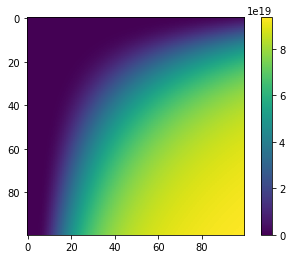

In [9]:
image3 = plt.imshow(DerMap)
plt.colorbar(image3)

In [10]:
print(DiskModel.GetGeometricUnit())
print(DiskModel.AngDiameterDistance())
print(DiskModel.CalculateLuminosityDistance())
print(DiskModel.mass)
print(DiskModel.mass_exponent)
print(DiskModel.inc_ang)

14766250380.50125 m
5.333192072166894e+25 m
4.7998728649502045e+26 m
1.988409870698051e+37 kg
7.0
40


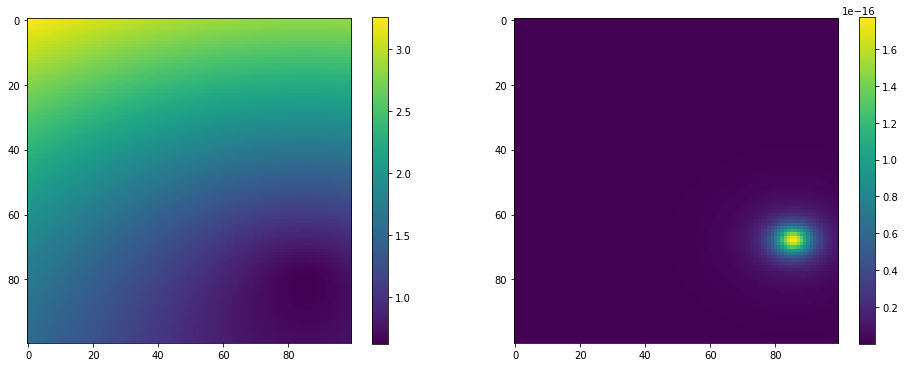

In [11]:
cheight = 6
axisoffset = 50
angleoffset = 315
delaymap = DiskModel.CreateTimeDelayMap(cheight, axisoffset=axisoffset, angleoffset=angleoffset)
geomap = DiskModel.CreateGeometricFactorMap(cheight, axisoffset=axisoffset, angleoffset=angleoffset)
fig, ax = plt.subplots(1,2, figsize=(16,6))
img = ax[0].imshow(delaymap)
img2 = ax[1].imshow(geomap)
plt.colorbar(img, ax=ax[0])
plt.colorbar(img2, ax=ax[1])

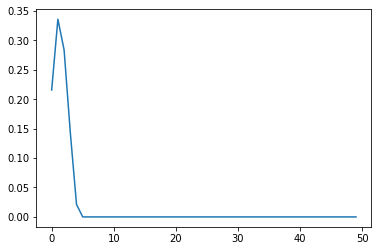

In [12]:
tf = DiskModel.ConstructDiskTransferFunction(DiskModel.temp_map, cheight, axisoffset=axisoffset, angleoffset=angleoffset)
plt.plot(tf[:50])

In [13]:
magdir = '/Users/henrybest/PythonStuff/LensingMaps/image_2237_b_zoom2.fits'
MagnificationMap = Amoeba.MagnificationMap(2.0, 1.0, magdir, 0.38, 0.42)

In [14]:
print(MagnificationMap.name)
print(MagnificationMap.zq)
print(MagnificationMap.zl)
print(MagnificationMap.file_name)
print(MagnificationMap.m_lens)
print(MagnificationMap.resolution)
print(MagnificationMap.ray_to_mag_ratio)



2.0
1.0
/Users/henrybest/PythonStuff/LensingMaps/image_2237_b_zoom2.fits
1.988409870698051e+30 kg
10000
0.7965659850229427


<ipython-input-15-162c28278094>:2: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(MagnificationMap.mag_map))


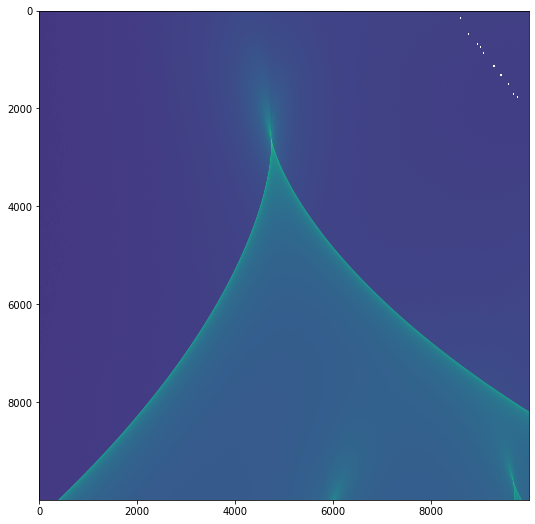

In [15]:
fig, ax = plt.subplots(figsize=(9,9))
ax.imshow(np.log(MagnificationMap.mag_map))

In [16]:
convolution1 = MagnificationMap.Convolve(DiskModel,BrightnessMap)
convolution2 = MagnificationMap.Convolve(DiskModel,BrightnessMap,rotation=45)

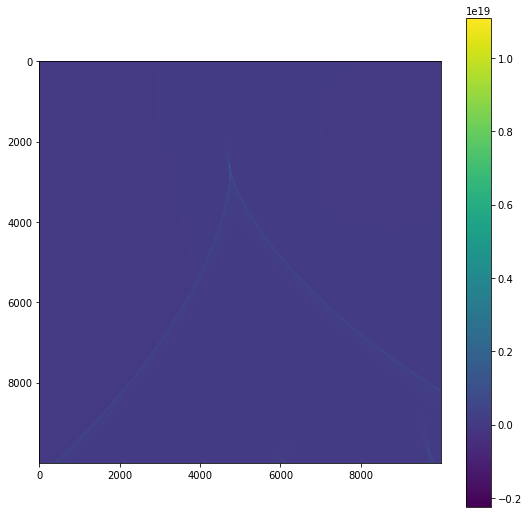

In [17]:
fig, ax = plt.subplots(figsize=(9,9))
vals = ax.imshow((convolution1.real-convolution2.real))
fig.colorbar(vals)

In [18]:
print(DiskModel.pxsize)
print(MagnificationMap.CalcMapPixSize())


14766250380.50125 m
38460996492.75478 m


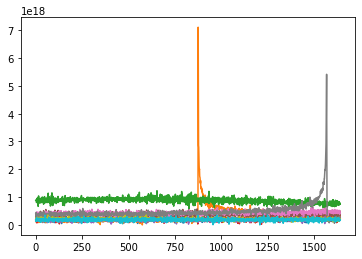

In [19]:
random.seed(100)

for jj in range(10):
    LC = MagnificationMap.PullRandomLightCurve(convolution1.real, 500, 4)
    plt.plot(LC)

In [20]:
with fits.open("/Users/henrybest/PythonStuff/Code/SampleData.fits") as f:
    v1 = f[0].header['v1']
    v2 = f[0].header['v2']
    v3 = f[0].header['v3']
    v4 = f[0].header['v4']
    m1 = f[0].data
    m2 = f[1].data
    m3 = f[2].data
disk = Amoeba.ThinDisk(v1, v2, v3, v4, m1, m2, m3)
    

In [21]:
print(disk.pxsize/disk.GetGeometricUnit())

1.0


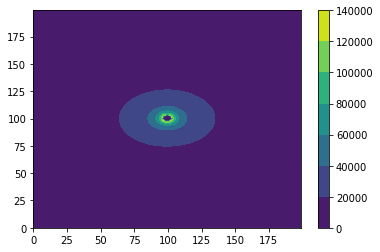

In [22]:
conts = plt.contourf((m1)) #Temperature Map
plt.colorbar(conts)

In [23]:
BrightnessMap, wavelengths= disk.CreateObservedSurfaceIntensityMap(800)

/usr/local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


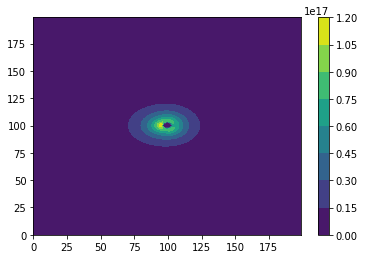

In [24]:
conts = plt.contourf((BrightnessMap))
plt.colorbar(conts)

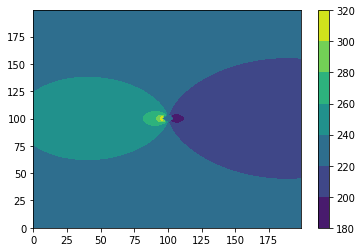

In [25]:
conts = plt.contourf((wavelengths))
plt.colorbar(conts)

/Users/henrybest/PythonStuff/Code/Amoeba.py:123: RuntimeWarning: invalid value encountered in true_divide
  return a.value * b.value / (b.value - 1)**2


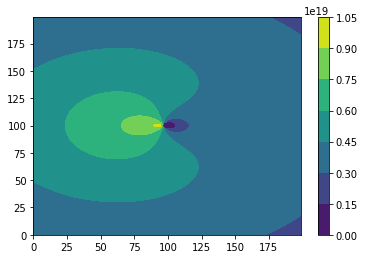

In [26]:
ReprocessMap = disk.CreateReprocessedEmissionMap(800)
conts = plt.contourf(ReprocessMap)
plt.colorbar(conts)

In [27]:
TF1 = disk.ConstructDiskTransferFunction(ReprocessMap, 20, weight=True)
TF2 = disk.ConstructDiskTransferFunction(ReprocessMap, 10, weight=True)

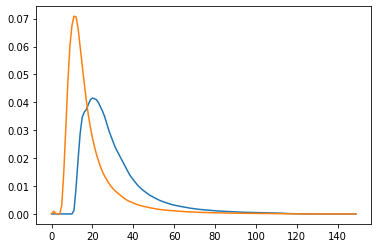

In [28]:
lim=150
plt.plot(TF1[:lim])
plt.plot(TF2[:lim])